# Menu <a class="anchor" id="menu"></a>

* [1. Segmentation par **RFM** ](#rfm)
    * [1.1 Calcul de la `Recence`](#rfm_R)
    * [1.2 Calcul de la `Frequence`](#rfm_F)
    * [1.3 Calcul du `Montant`](#rfm_M)
    * [1.4 Calcul des `scores RFM`](#rfm_scores)
    * [1.5 Interprétation des groupes](#rfm_interpretation)
    * [1.6 Conclusion](#rfm_conclusion)
* [2. Feature Engineering pour modèles non-supervisés](#fe)
* [3. Préparatifs pour les algorithmes non-supervisés](#setup)
* [4. Segmentation par **KMeans** ](#kmeans)
    * [4.1 Modèle de référence](#kmeans_ref)
    * [4.2 Modèle avec Feature Engineering](#kmeans_fe)
    * [4.3 Modèle avec Elbow method](#kmeans_elbow)
    * [4.4 Modèle avec Silhouettes](#kmeans_silhouette)
* [5. Segmentation par **CAH** ](#cah)
    * [5.1 Modèle de référence](#cah_ref)
    * [5.2 Modèle avec Feature Engineering](#cah_fe)
    * [5.3 Modèle avec determination automarique du nombre de clusters](#cah_auto)
    * [5.4 Modèle avec Silhouettes](#cah_silhouette)
* [6. Segmentation par **DBScan** ](#dbscan)
    * [6.1 Modèle de référence](#dbscan_ref)
    * [6.2 Modèle avec Feature Engineering](#dbscan_fe)
    * [6.3 Modèle avec Elbow method](#dbscan_elbow)
    * [6.4 Modèle avec GridSearchCV](#dbscan_silhouette)
* [7. Comparaison des modèles ](#unsupervised_comparison)

# La segmentation

Segmenter consiste à **créer des segments homogènes de clients** que l’on peut ensuite activer dans des campagnes marketing ciblées. Cette approche permet de mieux cibler les campagnes et scénarios marketing; on segmente les clients en fonction de critères de segmentation.

Il y a théoriquement autant de méthodes de segmentation qu’il y a de critères et de combinaisons de critères possibles. Mais certaines méthodes se sont imposées en raison de leur efficacité.

---
# Préparatifs 

In [1]:
import os
# import re
import time
# import math
# import string
import datetime
# import unicodedata
# import json
from zipfile import ZipFile
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

import warnings
warnings.filterwarnings('ignore')

random_seed = 0
np.random.seed(random_seed)
cmap_ref = 'nipy_spectral'

# import gc
# gc.enable()

In [2]:
def load_from_zip(csv_name):
    return pd.read_csv(ZipFile(os.path.join("data", f"{csv_name}.zip")).open(csv_name))


# data_geo = load_from_zip("olist_geolocation_dataset.csv")
# data_geo = pd.read_csv(os.path.join('data',"olist_geolocation_dataset_clean.csv"))

# data_customer = load_from_zip("olist_customers_dataset_clean.csv")
data_customer = pd.read_csv(os.path.join('data', "olist_customers_dataset_clean.csv"))

# data_orders = load_from_zip("olist_orders_dataset.csv")
data_orders = pd.read_csv(os.path.join('data', "olist_orders_dataset_clean.csv"))

# data_items = load_from_zip("olist_order_items_dataset.csv")
data_items = pd.read_csv(os.path.join('data', "olist_order_items_dataset_clean.csv"))

# data_products = load_from_zip("olist_products_dataset.csv")
# data_products = pd.read_csv(os.path.join('data',"olist_products_dataset_clean.csv"))

# data_payments = load_from_zip("olist_order_payments_dataset.csv")
data_payments = pd.read_csv(os.path.join('data', "olist_order_payments_dataset_clean.csv"))

# data_reviews = load_from_zip("olist_order_reviews_dataset.csv")
data_reviews = pd.read_csv(os.path.join('data', "olist_order_reviews_dataset_clean.csv"))

# data_sellers = pd.read_csv(os.path.join('data',"olist_sellers_dataset_clean.csv"))
# data_categories = pd.read_csv(os.path.join('data',"product_category_name_translation_clean.csv"))

---
---
# 1. Segmentation RFM *(Récence, Fréquence et Montant)* <a class="anchor" id="rfm"></a> [⇪](#menu)

La segmentation RFM est l’une des techniques de segmentation incontournables pour améliorer le ciblage marketing et augmenter le revenu par client. 

Cette méthode est une **segmentation 100% comportementale**; on ne segmente pas  les clients en fonction de ce qu’ils sont *(genre, sexe, ville, CSP...)*, ni en fonction de ce qu’ils aiment *(centres d’intérêt, goûts)*, mais en fonction de ce qu’ils achètent.

Le principe sous-jacent est simple : un client qui a acheté récemment, qui achète fréquemment et qui génère beaucoup de chiffre d’affaires commandera à nouveau, à coup quasiment sûr.

La segmentation RFM repose sur ces 3 critères :
- La **Récence** : Combien de temps s’est-il écoulé depuis la dernière activité du client *(achat/visite web/visite app...)* ?
- La **Fréquence** : Au cours d’une période de temps donnée, combien de fois un client a-t-il acheté ou interagi avec la marque ? 
- Le **Montant** : Combien un client a-t-il dépensé d’argent au cours d’une période de temps donnée ?

## Préparatifs

> **Temporalité** : comme nos analyses ont montrés que l'activité n'était pas fiable au début et à la fin de la timeline disponible, nous pourrions restreintre notre jeu de données entre **Janvier 2017** et **Aout 2018**. Mais comme il est recommandé de faire une RFM sur une période cyclique et réutilisable d'une semaine, d'un mois ou d'une année, nous allons prendre les données allant de fin août 2017 à fin août 2018 (donc les données les plus récentes sur 1 an).

#### D'abord on restreint la selection entre le 01/09/2017 et le 01/09/2018 pour avoir une période d'un an et on ne garde que ceux dont le processus de livraison est allé jusqu'au bout (delivered)

In [3]:
selection1 = data_orders[
    (data_orders.order_purchase_timestamp >= '2017-09-01 00:00:00') & 
    (data_orders.order_purchase_timestamp < '2018-09-01 00:00:00') & 
    (data_orders.order_status == 'delivered')][['order_id', 'customer_id', 'order_purchase_timestamp']]
selection1.head()

,order_id,customer_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39


#### Puis on associe ces commandes aux id uniques des clients qui les ont passées

In [4]:
selection2 = selection1.merge(data_customer[['customer_id', 'customer_unique_id']], on='customer_id', how='left')
selection2.head()

,order_id,customer_id,order_purchase_timestamp,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6


## 1.1 Calcul de la `Récence` <a class="anchor" id="rfm_R"></a> [⇪](#menu)

#### On converti la date d'achat en nombre de jours écoulés *(depuis le moment ou l'on arrête notre selection donc le 01/09/2018)*

In [5]:
ref_date = datetime.datetime.strptime('2018-09-01 00:00:00', '%Y-%m-%d %H:%M:%S')
selection3 = selection2.copy()

selection3.order_purchase_timestamp = selection2.order_purchase_timestamp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
selection3['days_ago'] = selection3.order_purchase_timestamp - ref_date
selection3['days_ago'] = selection3.days_ago.apply(lambda x: x.days)
selection3.drop(columns=['order_purchase_timestamp'], inplace=True)
selection3.head()

,order_id,customer_id,customer_unique_id,days_ago
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,-334
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,-39
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,-24
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,-287
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,-200


In [6]:
selection3.describe().T

,count,mean,std,min,25%,50%,75%,max
days_ago,74213.0,-176.203778,99.367873,-365.0,-263.0,-176.0,-92.0,-3.0


#### Puis, on crée une **nouvelle table** `R_data` qui stoque la **recence** *(la plus petite valeur `days_ago`)* de chaque client

In [7]:
R_data = selection3[['customer_unique_id', 'days_ago']].groupby('customer_unique_id').min().reset_index()
R_data.rename(columns={'days_ago': 'recence'}, inplace=True)
R_data.head()

,customer_unique_id,recence
0,0000366f3b9a7992bf8c76cfdf3221e2,-114
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-117
2,0000f6ccb0745a6a4b88665a16c9f078,-324
3,0004aac84e0df4da2b147fca70cf8255,-291
4,0004bd2a26a76fe21f786e4fbd80607f,-149


In [8]:
R_data.describe().T

,count,mean,std,min,25%,50%,75%,max
recence,72247.0,-176.54805,99.464265,-365.0,-264.0,-176.0,-92.5,-3.0


## 1.2 Calcul de la `Fréquence` <a class="anchor" id="rfm_F"></a> [⇪](#menu)

#### On ajoute la fréquence de chaque commande; c'est à dire 1...

In [9]:
selection4 = selection3.copy()
selection4['frequence'] = 1

#### Puis, on crée une **nouvelle table** `F_data` qui stoque la **frequence** *(le total du nombre de commande passées dans la période choisie)* de chaque client

In [10]:
F_data = selection4[['customer_unique_id', 'frequence']].groupby('customer_unique_id').sum().reset_index()
F_data.sort_values('frequence', ascending=False).head()

,customer_unique_id,frequence
39752,8d50f5eadf50201ccdcedfb9e2ac8455,11
17595,3e43e6105506432c953e165fb2acf44c,9
28323,6469f99c1f9dfae7733b25662e7f1782,7
7709,1b6c7548a2a1f9037c1fd3ddfed95f33,7
57218,ca77025e7201e3b30c44b472ff346268,7


In [11]:
F_data.describe().T

,count,mean,std,min,25%,50%,75%,max
frequence,72247.0,1.027212,0.185742,1.0,1.0,1.0,1.0,11.0


## 1.3 Calcul du `Montant` <a class="anchor" id="rfm_M"></a> [⇪](#menu)

#### On calcul le montant total de chaque commande *(puisqu'il peut y avoir plusieurs moyens de paiements)*

In [12]:
total_amount_per_order = selection3[['order_id']].merge(
        data_payments[['order_id', 'payment_value']], on='order_id', how='left'
    ).groupby('order_id').sum().reset_index()
total_amount_per_order.rename(columns={'payment_value': 'montant'}, inplace=True)
total_amount_per_order.head()

,order_id,montant
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,000229ec398224ef6ca0657da4fc703e,216.87
2,00024acbcdf0a6daa1e931b038114c75,25.78
3,00054e8431b9d7675808bcb819fb4a32,31.75
4,000576fe39319847cbb9d288c5617fa6,880.75


#### Puis, on crée une **nouvelle table** `M_data` qui stoque le **montant** *(le total des montants de toutes les commandes faites sur la période choisie)* pour chaque client

In [13]:
M_data = selection3[['customer_unique_id', 'order_id']].merge(
        total_amount_per_order, on='order_id', how='left'
    ).groupby('customer_unique_id').sum().reset_index()
M_data.head()

,customer_unique_id,montant
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f6ccb0745a6a4b88665a16c9f078,43.62
3,0004aac84e0df4da2b147fca70cf8255,196.89
4,0004bd2a26a76fe21f786e4fbd80607f,166.98


In [14]:
M_data.describe().T

,count,mean,std,min,25%,50%,75%,max
montant,72247.0,164.548839,217.050575,0.0,63.13,108.2,182.14,7274.88


## 1.4 Calcul des `scores RFM` <a class="anchor" id="rfm_scores"></a> [⇪](#menu)

#### On associe les trois jeux de données `R_data`, `F_data` et `M_data` en un unique jeu de données `RFM_data`

In [15]:
RFM_data = reduce(lambda x, y: pd.merge(x, y, on='customer_unique_id', how='left'), [R_data, F_data, M_data])
RFM_data.sort_values(['frequence', 'recence', 'montant'], ascending=False)

,customer_unique_id,recence,frequence,montant
39752,8d50f5eadf50201ccdcedfb9e2ac8455,-361,11,557.15
17595,3e43e6105506432c953e165fb2acf44c,-348,9,1172.66
7709,1b6c7548a2a1f9037c1fd3ddfed95f33,-292,7,959.01
57218,ca77025e7201e3b30c44b472ff346268,-327,7,1122.72
28323,6469f99c1f9dfae7733b25662e7f1782,-347,7,758.83
...,...,...,...,...
45706,a1efe9a98bf03a0025efa9bc56fe9d1f,-365,1,35.00
53024,bb7ff07987c9bb0345b6b948478525b4,-365,1,31.75
35090,7c3db55121184d445bec70d421c62135,-365,1,31.38
69236,f514fa8c60b510de4c90242e86801717,-365,1,31.10


In [16]:
RFM_data.describe().T

,count,mean,std,min,25%,50%,75%,max
recence,72247.0,-176.548050,99.464265,-365.0,-264.00,-176.0,-92.50,-3.00
frequence,72247.0,1.027212,0.185742,1.0,1.00,1.0,1.00,11.00
montant,72247.0,164.548839,217.050575,0.0,63.13,108.2,182.14,7274.88


#### Puis, on utilise les quantiles pour calculer les seuil de répartition des scores pour chacune des 3 colonnes...

In [17]:
num_groups = 3  # En combien de groupes voulont nous découper nos scores

R_groups = RFM_data.recence.quantile(np.linspace(0, 1, num_groups+1))
R_groups.pop(0)

F_groups = RFM_data.frequence.quantile(np.linspace(0, 1, num_groups+1))
F_groups.pop(0)

M_groups = RFM_data.montant.quantile(np.linspace(0, 1, num_groups+1))
M_groups.pop(0)

0.0

In [18]:
r_start, f_start, m_start = 0,0,0
for i, (r, f, m) in enumerate(zip(R_groups, F_groups, M_groups)):
    print(f"score:{i} | Recence:[{r_start:6};{r:6}] | Frequence:[{f_start:6};{f:6}] | Montant:[{m_start:6};{m:6}]")
    r_start, f_start, m_start = r, f, m

score:0 | Recence:[     0;-229.0] | Frequence:[     0;   1.0] | Montant:[     0; 75.25]
score:1 | Recence:[-229.0;-122.0] | Frequence:[   1.0;   1.0] | Montant:[ 75.25;152.71]
score:2 | Recence:[-122.0;  -3.0] | Frequence:[   1.0;  11.0] | Montant:[152.71;7274.88]


>#### 🔔 On note que les **scores de fréquence vont présenter un problème** puisque le score 2 est inexistant de par la répartition des achats
> *(rappelons que notre Analyse Exploratoire des données a montrée que seuls environ 3% des clients font plus d'un achat)*

#### On utilise les seuils pour calculer et ajouter les scores `R_score`, `F_score` et `M_score` des 3 colonnes `recence`, `frequence` et `montant`

In [19]:
def eval_score(x, split_values):
    for i, v in enumerate(split_values):
        if(x <= v):
            return i+1

    print(f"probleme: value={x}\n", split_values)
    raise Exception


RFM_data['R_score'] = RFM_data.recence.apply(eval_score, split_values=R_groups)
RFM_data['F_score'] = RFM_data.frequence.apply(eval_score, split_values=F_groups)
RFM_data['M_score'] = RFM_data.montant.apply(eval_score, split_values=M_groups)
RFM_data['RFM_score'] = RFM_data[['R_score', 'F_score', 'M_score']].apply(
    lambda row: int(''.join(row.values.astype(str))), axis=1
)

In [20]:
RFM_data.sort_values(['recence', 'frequence', 'montant'], ascending=False)

,customer_unique_id,recence,frequence,montant,R_score,F_score,M_score,RFM_score
26076,5c58de6fb80e93396e2f35642666b693,-3,1,510.96,3,1,3,313
49731,afbcfd0b9c5233e7ccc73428526fbb52,-3,1,497.25,3,1,3,313
3475,0c6d7218d5f3fa14514fd29865269993,-3,1,178.25,3,1,3,313
1154,0421e7a23f21e5d54efed456aedbc513,-3,1,119.42,3,1,2,312
51155,b4dcade04bc548b7e3b0243c801f8c26,-3,1,106.95,3,1,2,312
...,...,...,...,...,...,...,...,...
45706,a1efe9a98bf03a0025efa9bc56fe9d1f,-365,1,35.00,1,1,1,111
53024,bb7ff07987c9bb0345b6b948478525b4,-365,1,31.75,1,1,1,111
35090,7c3db55121184d445bec70d421c62135,-365,1,31.38,1,1,1,111
69236,f514fa8c60b510de4c90242e86801717,-365,1,31.10,1,1,1,111


## 1.5 Interprétation  <a class="anchor" id="rfm_interpretation"></a> [⇪](#menu)

In [21]:
RFM_groups_size = RFM_data.groupby('RFM_score').size()
RFM_groups_size

RFM_score
111    8011
112    7962
113    7491
131      20
132     204
133     606
211    8114
212    7525
213    7561
231      34
232     140
233     502
311    7914
312    8158
313    7717
331      11
332      73
333     204
dtype: int64

>#### On pourrait les intérpêter comme suit:
>
> **Champions** | RFM_score = **333**
>> A acheté récemment, achète souvent et dépense le plus.<br>
>> Récompensez-les. Ils peuvent devenir des early adopters de vos nouveaux produits. Ils vont promouvoir votre marque.
>
> **Clients fidèles** | RFM_score = **233** ou **332**
>> Dépense pas mal d’argent et assez souvent. Sensible aux promotions.<br>
>> Proposez-leur des produits de gamme supérieure (up-sell). Demandez-leur des feedbacks. Engagez-les.
>
> **Clients récents**  | RFM_score = **313**, **312** ou **311**
>> A acheté récemment mais n’achète pas souvent.<br>
>> Envoyez-leur un programme d’onboarding. Construisez une relation clients.
>
> **Clients à risque** | RFM_score = **133**
>> A dépensé beaucoup d’argent et acheté souvent... mais il y a très longtemps. Vous devez les faire revenir à vous !<br>
>> Envoyez-leur des emails personnalisés pour reconnecter avec eux. Offrez-leur des promotions sur leur renouvellement. Fournissez-leur des ressources utiles.
>
> **Clients que vous ne devez pas perdre** | RFM_score = **123** ou **132**
>> A fait les plus gros achats et acheté souvent. Mais cela fait un moment qu’il n’a plus racheté.<br>
>> Reconquérez-les avec des promotions ou des nouveaux produits. Ne les laissez pas partir chez la concurrence, parlez-leur.
>
> **Clients en hibernation** | RFM_score = **112** ou **113**
>> Son dernier achat remonte à il y a moment... Ne dépense pas beaucoup et pas souvent du tout.<br>
>> Offrez-leur des promotions spéciales, présentez-leur des produits pertinents. Recréez de la brand value.
>
> **Clients perdus** | RFM_score = **111**
>> A les plus faibles scores en Récence, Fréquence et Montant.<br>
>> Essayez de réveiller leur intérêt avec une campagne, sinon laissez tomber.

#### Enfin, on peut afficher ces groupes sous forme de `treemap`

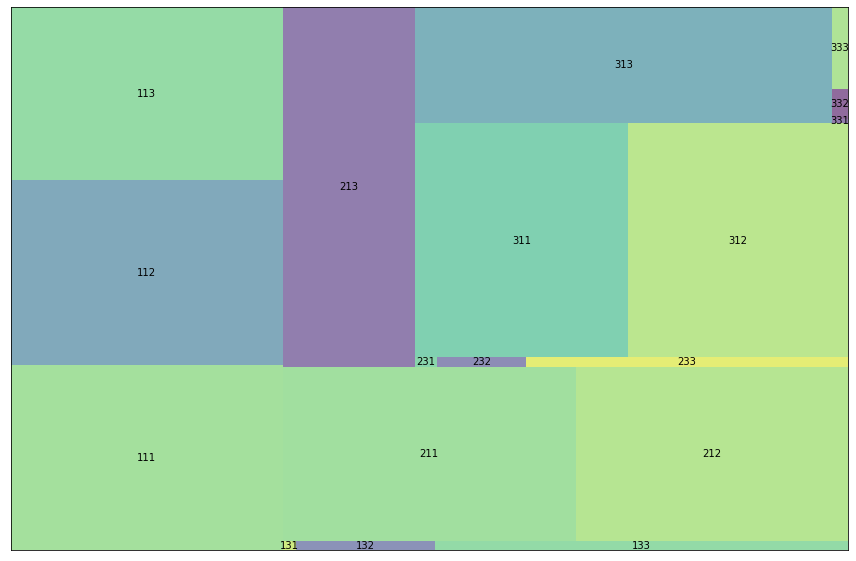

In [22]:
fig = plt.figure(figsize=(15, 10))
ax = squarify.plot(sizes=RFM_groups_size, label=RFM_groups_size.keys(), alpha=0.6)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

## 1.6 Conclusion  <a class="anchor" id="rfm_conclusion"></a> [⇪](#menu)

> #### Dans le cas présent, la méthode RFM ne semble pas adaptée.
> En effet, les scores de Fréquence sont difficile à découper en raison du trop grand nombre de clients qui ne font qu'un seul achat.<br>
> Il semble donc plus approprié de se diriger vers des méthodes de ségmentation non-supervisées telles que `KMeans`, `DBScan` ou le `Hierarchical Clustering`.

---
---
# 2. Feature Engineering <a class="anchor" id="fe"></a> [⇪](#menu)

>#### Nous avons vu avec la ségmentation RFM que si les variables `Recense` et `Montant` peuvent être utile au découpage des groupes, il n'en est pas de même pour la variable `Fréquence` que nous devons mettre de coté.

## 2.1 Regardons comment se répartissent nos clients avec ces deux seules variables...

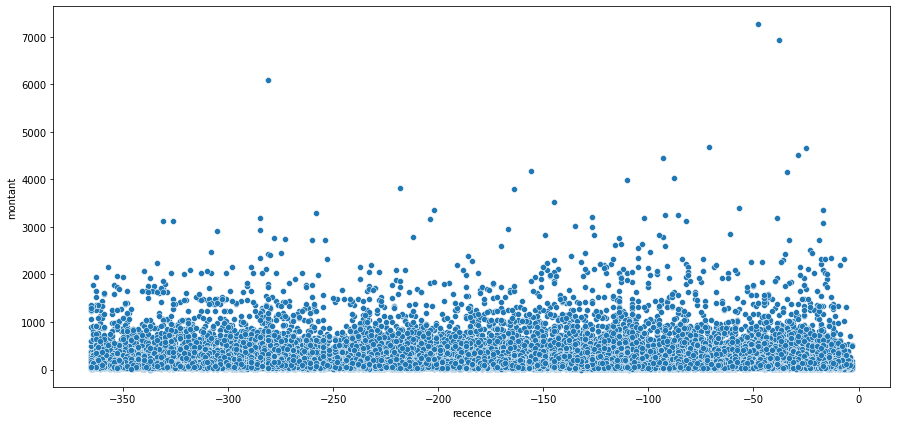

In [23]:
fig = plt.figure(figsize=(15, 7))
sns.scatterplot(x=RFM_data['recence'], y=RFM_data['montant'])
plt.show()

>#### Il va être difficile de ségmenter correctement avec seulement ces 2 variables
> *(le plus probable est de voir apparaitre une ségmentation sur un seul axe)*.
> 
> Il va donc falloir compléter le jeu de données avec plus de variables issues de nos 9 jeux de données initiaux, ou encore créer de nouvelles variables utiles.

## 2.2 Ajoutons d'autres variables pour aider à créer des clusters

#### Préparons une table de référence qui nous permettra de faire les jointures sur toutes les tables utiles 

In [24]:
data_base_join = selection2[['order_id', 'customer_id', 'customer_unique_id']]
data_base_join.head(2)

,order_id,customer_id,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231


In [25]:
data_base_join.shape

(74213, 3)

#### Préparons notre nouveau jeu de données avec les colonnes `Recence` et `Montant` du RFM
> C'est à cette nouvelle table que l'on va ajouter petit à petit les variables que l'on va préparer ou récupèrer des autres datasets

In [26]:
data_clustering = data_base_join[['customer_unique_id']].merge(
        RFM_data[['customer_unique_id', 'recence', 'montant']],
        on='customer_unique_id', how='left'
    )
data_clustering.head(2)

,customer_unique_id,recence,montant
0,7c396fd4830fd04220f754e42b4e5bff,-362,82.82
1,af07308b275d755c9edb36a90c618231,-39,141.46


In [27]:
data_clustering.shape

(74213, 3)

### `olist_order_reviews_dataset.csv`
> ajoutons **les notes** données aux commandes par les clients et **le temps de réponse** à l'enquête de satisfaction *(que nous avions calculés lors de l'EDA)*.

#### Nous allons d'abord récupèrer ces variables `par commande`

In [28]:
data_fe1 = data_base_join.merge(
        data_reviews[['order_id', 'review_score', 'answer_days']].groupby('order_id').last(), 
        on='order_id', how='left'
    )
data_fe1.shape

(74213, 5)

In [29]:
data_fe1.head(2)

,order_id,customer_id,customer_unique_id,review_score,answer_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,4.0,1.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,4.0,0.0


#### Puis en faire la moyenne `par client`

In [30]:
data_fe2 = data_fe1.groupby('customer_unique_id').mean().reset_index()
data_fe2.head(2)

,customer_unique_id,review_score,answer_days
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,4.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,0.0


In [31]:
data_fe2.shape

(72247, 3)

#### On vérifie que l'on a pas perdu ou ajouté de lignes dans les jointures...

In [32]:
selection2.customer_unique_id.nunique()

72247

#### On applique les nouvelles valeurs sur le jeu de données `data_clustering`

In [33]:
data_clustering = data_clustering.merge(data_fe2, on='customer_unique_id', how='left')
data_clustering.head(2)

,customer_unique_id,recence,montant,review_score,answer_days
0,7c396fd4830fd04220f754e42b4e5bff,-362,82.82,4.5,1.0
1,af07308b275d755c9edb36a90c618231,-39,141.46,4.0,0.0


In [34]:
data_clustering.shape

(74213, 5)

### `olist_order_items_dataset.csv`
> ajoutons **le nombre moyen de produits** et le **le nombre total de produits** commandé par client

#### Nous allons d'abord récupèrer ces variables `par commande`

In [35]:
data_fe = data_items.groupby('order_id').last()[['order_item_id']].reset_index()
data_fe.head(2)

,order_id,order_item_id
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1


In [36]:
data_fe = data_base_join.merge(data_fe, on='order_id', how='left')
data_fe.head(2)

,order_id,customer_id,customer_unique_id,order_item_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,1


In [37]:
data_fe.shape

(74213, 4)

#### Puis en faire la moyenne `par client`

In [38]:
data_fe2 = data_fe.groupby('customer_unique_id').mean().reset_index()
data_fe2.rename(columns={'order_item_id': 'mean_items'}, inplace=True)
data_fe2.head(2)

,customer_unique_id,mean_items
0,0000366f3b9a7992bf8c76cfdf3221e2,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1.0


In [39]:
data_fe2.describe().T

,count,mean,std,min,25%,50%,75%,max
mean_items,72247.0,1.141812,0.533297,1.0,1.0,1.0,1.0,20.0


In [40]:
data_fe3 = data_fe.groupby('customer_unique_id').sum().reset_index()
data_fe3.rename(columns={'order_item_id': 'total_items'}, inplace=True)
data_fe3.head(2)

,customer_unique_id,total_items
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1


In [41]:
data_fe3.describe().T

,count,mean,std,min,25%,50%,75%,max
total_items,72247.0,1.175647,0.616571,1.0,1.0,1.0,1.0,24.0


In [42]:
data_clustering = data_clustering.merge(data_fe2, on='customer_unique_id', how='left')
data_clustering = data_clustering.merge(data_fe3, on='customer_unique_id', how='left')
data_clustering.head(2)

,customer_unique_id,recence,montant,review_score,answer_days,mean_items,total_items
0,7c396fd4830fd04220f754e42b4e5bff,-362,82.82,4.5,1.0,1.0,2
1,af07308b275d755c9edb36a90c618231,-39,141.46,4.0,0.0,1.0,1


In [43]:
data_clustering.shape

(74213, 7)

### `olist_orders_dataset.csv`
> ajoutons **le temps de livraison moyen** des commandes pour chaque client

#### Nous allons d'abord récupèrer ces variables `par commande`

In [44]:
data_fe = data_base_join.merge(
        data_orders[['order_id', 'delivery_days']].groupby('order_id').last(), 
        on='order_id', how='left'
)
data_fe.head(2)

,order_id,customer_id,customer_unique_id,delivery_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,14.0


In [45]:
data_fe.shape

(74213, 4)

#### Puis en faire la moyenne `par client`

In [46]:
data_fe2 = data_fe.groupby('customer_unique_id').mean().reset_index()
data_fe2.head(2)

,customer_unique_id,delivery_days
0,0000366f3b9a7992bf8c76cfdf3221e2,6.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3.0


In [47]:
data_fe2.shape

(72247, 2)

#### On applique les nouvelles valeurs sur le jeu de données `data_clustering`

>#### 🔔 Finalement je ne l'applique pas, car j'ai découvert que c'était inversement corrélé avec la variable `review_score`

---
---
# 3. Préparatifs pour les algorithmes d'apprentissage non-supervisés  <a class="anchor" id="setup"></a> [⇪](#menu)

- 🚩 **TODO** ICI on parle de l'apprentisage suppervisé 
- 🚩 **TODO** ICI on explique que l'on a pas besoin de train/validation/test split
> La plupart des algorithmes de clustering ne peuvent pas "prédire" pour de nouvelles données. K-means est une rare exception, car vous pouvez effectuer une classification par plus proche voisin sur les centroïdes pour prédire. Mais pour toute méthode qui n'utilise pas les centroïdes, on ne voit pas très bien comment on pourrait appliquer cela à des données "test".
- 🚩 **TODO** ICI on parle de la metric utilisé dans le cadre du clustering --> silhouette (ses avantages, ses défauts, ses bornes -1/+1 etc.)

## 3.1 Préparons le jeu de données

### Supprimons la colonne `customer_unique_id` qui était utile pour faire les jointures, mais qui ne l'est pas pour le clustering

In [48]:
X_cluster = data_clustering[[*data_clustering.select_dtypes(include='number')]].copy()
X_cluster.head(2)

,recence,montant,review_score,answer_days,mean_items,total_items
0,-362,82.82,4.5,1.0,1.0,2
1,-39,141.46,4.0,0.0,1.0,1


In [49]:
X_cluster.shape

(74213, 6)

### Supprimons les `NaN`

In [50]:
X_cluster.isnull().mean()

recence         0.000000
montant         0.000000
review_score    0.006158
answer_days     0.006158
mean_items      0.000000
total_items     0.000000
dtype: float64

In [51]:
X_cluster.dropna(inplace=True)

In [52]:
X_cluster.isnull().mean()

recence         0.0
montant         0.0
review_score    0.0
answer_days     0.0
mean_items      0.0
total_items     0.0
dtype: float64

In [53]:
X_cluster.shape

(73756, 6)

### Normalisons les variables
> En effet, dans la mesure où nous allons utiliser des algorithmes basés sur la distance et ou l'on constate clairement des différences d'échelles, il est préférable de normaliser nos données.

In [54]:
from sklearn.preprocessing import MinMaxScaler  # StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder,

In [55]:
def fit_normalizer(data):
    """ Normalize the values of the provided dataset

    Parameters
    ----------
    data: pandas' DataFrame
        the dataset used as reference for the scaler

    Returns
    -------
    MinMaxScaler
        the scaler instance
    """

    scaler = MinMaxScaler()
    scaler.fit(data)

    return scaler


def normalize(data, scaler):
    """ Transform the provided dataset using the provided scaler.

    Parameters
    ----------
    data: pandas' DataFrame
        the dataset that needs to be scaled
    scaler: MinMaxScaler 
        the scaler instance to apply on the dataset

    Returns
    -------
    DataFrame
        a new dataframe with the scaled values
    """

    dt = data.copy()
    dt = pd.DataFrame(scaler.transform(dt), index=dt.index, columns=dt.columns)

    return dt


def get_inverse_normalization(scaler, data):
    """ Transform the provided dataset using the provided scaler back to the original scales

    Parameters
    ----------
    data: pandas' DataFrame
        the dataset that needs to be scaled
    scaler: MinMaxScaler 
        the scaler instance to apply on the dataset
    columns: list
        the list of columns to consider

    Returns
    -------
    DataFrame
        a new dataframe with the scaled values
    """
    
    return pd.DataFrame(scaler.inverse_transform(data), columns=data.columns)

In [56]:
model_scaler = fit_normalizer(X_cluster)
X_cluster_norm = normalize(X_cluster, model_scaler)

In [57]:
X_cluster_norm.head(2)

,recence,montant,review_score,answer_days,mean_items,total_items
0,0.008287,0.011384,0.875,0.002874,0.0,0.043478
1,0.900552,0.019445,0.750,0.000000,0.0,0.000000


In [58]:
X_cluster_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
recence,73756.0,0.517608,0.274942,0.0,0.276243,0.516575,0.748619,1.0
montant,73756.0,0.023218,0.030423,0.0,0.008797,0.015226,0.025741,1.0
review_score,73756.0,0.783465,0.324573,0.0,0.750000,1.000000,1.000000,1.0
answer_days,73756.0,0.006848,0.020018,0.0,0.000000,0.002874,0.008621,1.0
mean_items,73756.0,0.007565,0.028138,0.0,0.000000,0.000000,0.000000,1.0
total_items,73756.0,0.009570,0.032213,0.0,0.000000,0.000000,0.000000,1.0


### Créeons un jeu de données réduit pour que les algorithmes puissent travailler plus rapidement dans un premier temps

In [59]:
X_sample = X_cluster_norm.sample(frac=0.25, random_state=random_seed).reset_index(drop=True).copy()

## 3.2 Définissions des méthodes pour évaluer nos modèles

### Définissons la métrique utilisée par la fonction de recherche des hyper-paramètres

In [60]:
from sklearn.metrics import make_scorer, silhouette_score, silhouette_samples

In [61]:
def cv_silhouette_scorer(estimator, X_ref):
    estimator.fit(X_ref)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X_ref.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X_ref, cluster_labels)

### Définissons des fonctions pour afficher et enregistrer les scores

In [62]:
#from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance
import matplotlib.cm as cm

In [63]:
def draw_silhouette(fitted_model, X_ref, silhouette_avg=None):

    #fig, (ax1, ax2) = plt.subplots(1, 2)
    #fig.set_size_inches(15, 7)
    fig = plt.figure(figsize=(15, 7))

    if silhouette_avg is None:
        silhouette_avg = cv_silhouette_scorer(fitted_model, X_ref)

    n_clusters = fitted_model.n_clusters
    cluster_labels = fitted_model.labels_
    sample_silhouette_values = silhouette_samples(X_ref, cluster_labels)

    # 1st Plot showing the silhouettes
    ax1 = fig.add_subplot(121)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #color = cm.cmap_ref(float(i) / n_clusters)
        color = cm.nipy_spectral(float(i) / n_clusters)

        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    if len(X_ref.columns) > 2:
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(
            X_sample['recence'], X_sample['montant'], X_sample['review_score'],
            marker="o", lw=0, alpha=0.7,
            c=colors, edgecolor="k"
        )
        ax2.set_xlabel('recence')
        ax2.set_ylabel('montant')
        ax2.set_zlabel('review score')
        ax2.set_title("The 3D visualization of the clustered data.")
    else:
        ax2 = fig.add_subplot(122)
        ax2.scatter(
            X_ref.iloc[:, 0], X_ref.iloc[:, 1], 
            marker=".", lw=0, alpha=0.7, 
            c=cluster_labels, edgecolor="k", cmap=cmap_ref,
        )
        ax2.set_xlabel('recence')
        ax2.set_ylabel('review score')
        ax2.set_title("The 2D visualization of the clustered data.")

    plt.suptitle(f"Silhouette analysis with n_clusters = {n_clusters}", fontsize=14, fontweight="bold")
    plt.show()

In [64]:
scores_df = pd.DataFrame(columns=['Method', 'params', 'best_params', 'silhouette', 'Training time', 'Inference time'])
scores_path = 'data/scores.csv'
scores_df.to_csv(scores_path, index=False)


def get_clustering_scores(method_name, model, X_ref=None, param_grid=None, best_params=None, training_time=None, inference_time=None, register=False, **others):
    """ Compute / Display / Save scores for the provided model

    More precisely, it compute the scores then call various function to display and save them.

    Parameters
    ----------
    method_name: str
        the name used to identify the record in the list
    model: 
        the model that needs to be evaluated
    X_ref: list of lists
        the X values used to get the predictions
    param_grid: dict
        the parameter grid used to get the provided scores
    best_params: dict
        the best parameters found with the gridsearch
    training_time: float
        the time needed for the fitting process
    inference_time: float
        the time needed for the prediction process
    """

    if X_ref is None:
        X_ref = X_cluster

    silhouette_avg = cv_silhouette_scorer(model, X_ref)
    scores = {'silhouette': silhouette_avg}

    # Register score and replace if it already exists
    if register:
        save_score(method_name, param_grid, best_params, training_time, inference_time, **scores)

    # Basic report
    scores_str = ""
    for key in scores.keys():
        scores_str += f"{key.upper().rjust(20)} : {scores[key]:.4f}\n"

    print(f"--- {method_name} ---".ljust(100, '-'), "\n\n", scores_str, sep="")

    # Silhouette plot
    # visualizer = SilhouetteVisualizer(model, colors='yellowbrick', is_fitted=True)
    # visualizer.fit(X_ref)
    # visualizer.show();
    draw_silhouette(model, X_ref, silhouette_avg=silhouette_avg)

In [65]:
def save_score(method_name, param_grid, best_params, training_time, inference_time, **scores):
    """ Save the scores into the 'scores_df' DataFrame and to the 'scores_path' CSV file.
    Each call to this function appends exactly one row to the DataFrame and hence to the CSV.

    Parameters
    ----------
    method_name: str
        the name used to identify the record in the list
    param_grid: dict
        the parameter grid used to get the provided scores
    best_params: dict
        the best parameters found with the gridsearch
    training_time: float
        the time needed for the fitting process
    inference_time: float
        the time needed for the prediction process
    scores: list of parameters
        the scores to register
    """

    idx = np.where(scores_df.Method == method_name)[0]
    idx = idx[0] if idx.size > 0 else len(scores_df.index)

    silhouette = scores.get('silhouette', None)

    scores_df.loc[idx] = [method_name, param_grid, best_params, silhouette, training_time, inference_time]
    scores_df.to_csv(scores_path, index=False)

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Comme on a des algorithmes qui utilisent les distances, il est préférable de **normaliser les données** !

---
---
# 4. K-Means <a class="anchor" id="kmeans"></a> [⇪](#menu)

Le K-means clustering *(ou segmentation par K-moyennes)* est une technique qui vise à partitionner *n* observations en *k* clusters dans lesquels chaque observation appartient au cluster dont la moyenne est la plus proche. 

In [66]:
from sklearn.cluster import KMeans

## 4.1 Basic Kmeans <a class="anchor" id="kmeans_ref"></a> [⇪](#menu)
#### Commençons par regarder comment se comporte le K-means avec les données que nous avons déjà
*(hors Fréquence puisque l'on a vu que c'est une donnée peu pertinente avec seulement 3% des clients qui achètent plus d'une fois)*

In [67]:
X_basic = X_sample[['recence', 'montant']]
kmeans = KMeans(random_state=random_seed).fit(X_basic)

--- Kmeans [basic] ---------------------------------------------------------------------------------

          SILHOUETTE : 0.5053



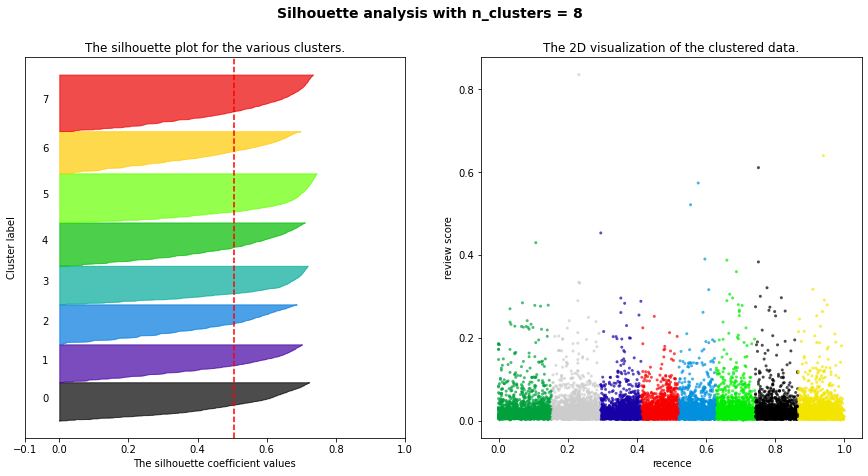

In [68]:
get_clustering_scores("Kmeans [basic]",  model=kmeans, X_ref=X_basic, register=True)

> Ce découpage ne présente aucun intérêt pour notre recherche de groupes types de clients.<br>
> Nous allons donc utiliser les variables supplémentaires que nous avons préparé un peu plus tôt.

## 4.2 KMeans + Feature Engineering  <a class="anchor" id="kmeans_fe"></a> [⇪](#menu)
#### Ajoutons les variables que nous avons préparé dans la section Feature Engineering

In [69]:
X_fe = X_sample
kmeans = KMeans(random_state=random_seed).fit(X_fe)

--- Kmeans [fe] ------------------------------------------------------------------------------------

          SILHOUETTE : 0.4542



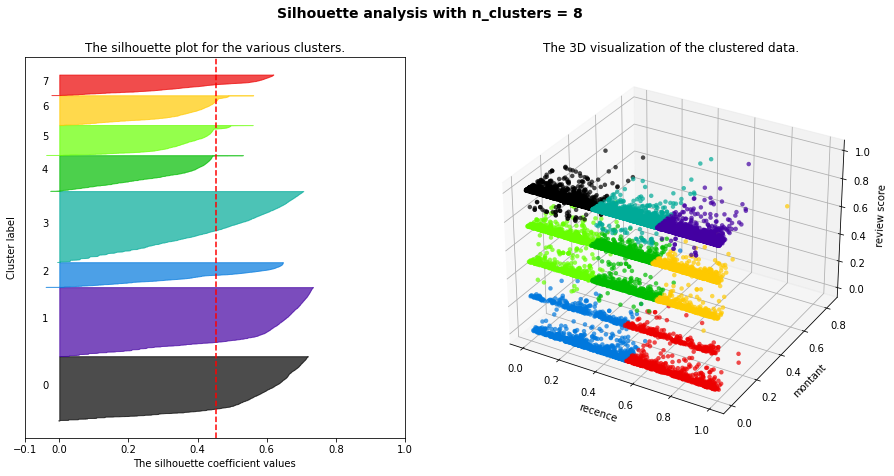

In [70]:
get_clustering_scores("Kmeans [fe]",  model=kmeans, X_ref=X_fe, register=True)

>#### On note que notre silhouette_score est à la baisse, mais on voit aussi clairement que le nombre de cluster choisi n'est pas du tout adapté...
> Nous allons donc essayer de trouver le nombre de cluster idéal

## 4.3 KMeans + Elbow method <a class="anchor" id="kmeans_elbow"></a> [⇪](#menu)
La Elbow method *(ou méthode du coude)* consiste à tester KMeans avec différentes valeurs de k pour sélectionner le nombre optimal de clusters. Comme on doit spécifier à l'avance le nombre de k à choisir, l'algorithme est quelque peu naïf - il affecte tous les membres à k clusters même si ce n'est pas le bon k pour l'ensemble de données. Idéalement, on choisit le point qui à la plus grande valeur *(selon la métrique choisie)* pour déterminer où se trouve le coude et donc choisir la valeur de **k**.

In [71]:
from yellowbrick.cluster import KElbowVisualizer

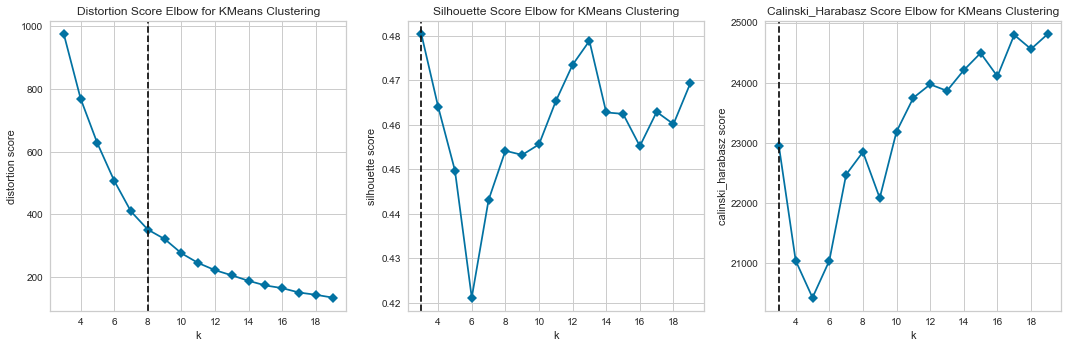

In [72]:
methods = ['distortion', 'silhouette', 'calinski_harabasz']
kmeans = KMeans(random_state=random_seed)

fig = plt.figure(figsize=(15, 5))
for i, m in enumerate(methods):
    ax = plt.subplot(1, 3, i+1)
    visualizer = KElbowVisualizer(kmeans, k=(3, 20), metric=m, timings=False)
    visualizer.fit(X_sample)
    plt.title(f"{m.title()} Score Elbow for KMeans Clustering")
    ax.set_ylabel(f'{m} score')
    ax.set_xlabel('k')
    #visualizer.show();

plt.tight_layout()
plt.show()

>#### Les trois métriques ne donnent pas le même résultat.
> - Le **distorition score** *(la somme moyenne des carrés des distances aux centres)* nous suggère **8 clusters** avec un coude très très légèrement marqué.
> - Le **silhouette score** *(le rapport moyen de la distance intra-cluster et de la distance au cluster le plus proche)* nous suggère **3 clusters** c'est à dire le minimum, et **13 clusters** semblent être une alternative intéressante *(mais bien trop grande pour une ségmentation de clientèle)*.
> - Le **calinski_harabasz score** *(rapport de la dispersion intra- et inter-clusters.)* nous suggère **3 clusters** c'est à dire le minimum proposé.
>
> Comme ce n'est pas vraiment tranché, nous allons utiliser les graphiques détaillés des silhouettes *(dont le score ci-dessous n'est que la moyenne)* pour essayer de comprendre plus précisement ce qui se passe.

## 4.4 KMeans + Silhouettes <a class="anchor" id="kmeans_silhouette"></a> [⇪](#menu)
Affichons les courbes silhouettes pour diverses valeurs **k** pour mieux visualiser le clustering

In [73]:
def plot_silhouette(model, data):

    model = model.fit(data)
    score = silhouette_score(data, model.labels_)
    print(f"Silhouette score moyen: {score:.3f}")

    # plt.figure(figsize=(10, 7))
    # visualizer = SilhouetteVisualizer(model, colors='yellowbrick', is_fitted=True)
    # visualizer.fit(data)
    # visualizer.show();
    draw_silhouette(model, data, silhouette_avg=score)

    return model

In [74]:
def get_means(fitted_model, X_cluster):
    X_labels = pd.DataFrame(fitted_model.labels_, columns=['label'])
    X_results = X_cluster.merge(X_labels, left_index=True, right_index=True)

    groups = {}
    for i in range(fitted_model.n_clusters):
        groups[i] = X_results[X_results.label == i].mean()

    return pd.DataFrame.from_dict(groups).T.drop(columns=['label'])

#### Silhouette avec **3 clusters**

Silhouette score moyen: 0.480


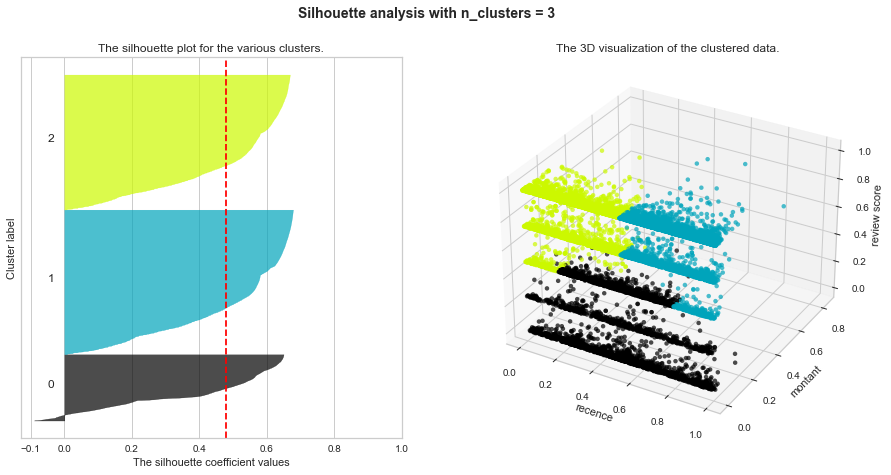

In [75]:
fitted_model = plot_silhouette(KMeans(n_clusters=3, random_state=random_seed), X_sample)

In [76]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample)).sort_values(['recence'])

,recence,montant,review_score,answer_days,mean_items,total_items
2,-268.505627,163.755017,4.689431,2.613890,1.112123,1.217591
0,-189.574908,182.391430,1.784677,2.331862,1.282018,1.358539
1,-89.529374,164.360296,4.705270,2.153644,1.119764,1.169628


>#### On constate que:
> - les 3 groupes sont bien découpé et donc la suggestion des 3 groupes faites par la recherche du coude sur le score de silhouette est sensé.
> - mais en regardant les valeurs moyennes des variables ont se rnd compte que ces groupes n'apportent pas grand chose (c'est surtout basé sur la recence; donc on a des clients actifs, des clients inactifs et le reste entre les deux...)
> - les silhouettes montrent des points mal classés sur le groupe 0.
> - on a un score intéressant de 0.48
>
> Malgré son score très correct, ça ne semble pas être le découpage idéal...

#### Silhouette avec **4 clusters**

Silhouette score moyen: 0.464


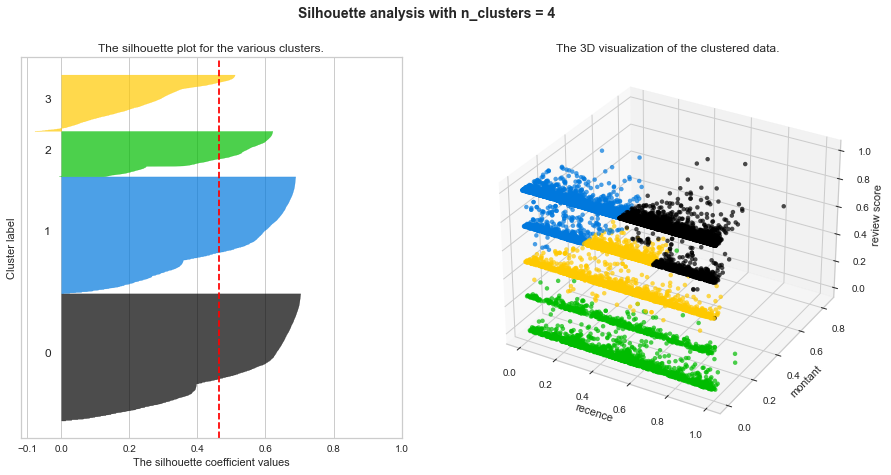

In [77]:
fitted_model = plot_silhouette(KMeans(n_clusters=4, random_state=random_seed), X_sample)

In [78]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample)).sort_values(['recence'])

,recence,montant,review_score,answer_days,mean_items,total_items
1,-273.421078,162.992887,4.828986,2.534459,1.111477,1.211742
3,-185.877707,163.601270,3.470830,2.573139,1.148441,1.252916
2,-185.779892,190.004100,1.229417,2.269204,1.324576,1.383120
0,-85.579638,165.558606,4.839030,2.157986,1.118069,1.167231


>#### On constate que:
> - on garde à peu près les mêmes groupes qu'avec 3 clusters (clients actifs / clients peu actifs / clients inactifs)
> - mais le groupe des peu actifs se divise en 2 sous groupes *(2,3)*: ceux qui sont mécontents et ont dépensés plus que la moyenne et ceux qui sont plutôt contents et ont dépensés dans la moyenne.
> - les silhouettes montrent des points mal classés sur le groupe 3.
> - on a un score à la baisse.
>
> Ça ne semble là encore pas être le découpage idéal.

#### Silhouette avec **5 clusters**

Silhouette score moyen: 0.450


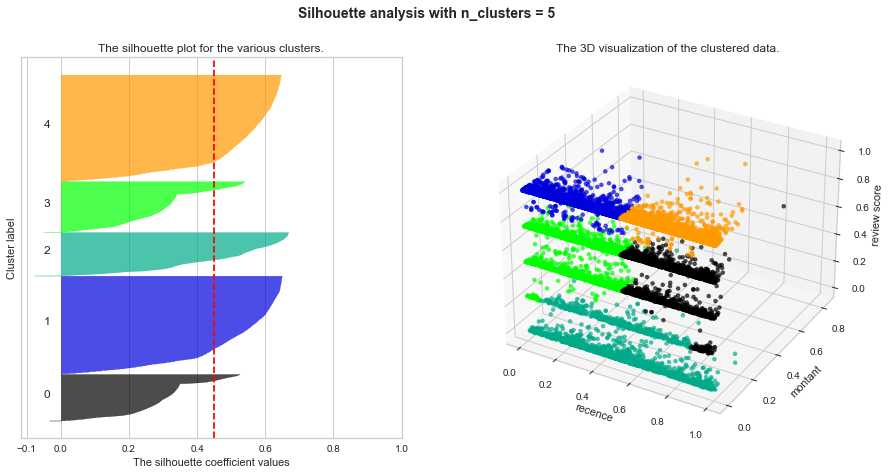

In [79]:
fitted_model = plot_silhouette(KMeans(n_clusters=5, random_state=random_seed), X_sample)

In [80]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample)).sort_values(['recence'])

,recence,montant,review_score,answer_days,mean_items,total_items
1,-267.314373,161.893560,4.993278,2.562798,1.107804,1.215117
3,-263.381409,166.926359,3.642412,2.695613,1.134872,1.244559
2,-187.987511,192.011214,1.198608,2.260408,1.327663,1.388458
0,-92.291751,160.699525,3.671362,2.247384,1.158216,1.210060
4,-90.082013,166.150151,4.997008,2.126892,1.112959,1.162971


>#### On constate que:
> - ça se découpe en trois groupes majeurs (clients actifs / clients peu actifs / clients inactifs)
> - les clients actifs / clients inactifs se découpent en 2 sous groupes : ceux qui sont modèrement satisfaits et ceux qui sont satisafait.
> - les clients peu actifs *(cluster 2)* regroupent visiblement tous les mécontents.
> - les silhouettes montrent quelques points mal classés sur les groupes 2 et 3.
> - on a un score qui baisse encore.
> 
> Ce n'est pas dénué de sens, mais il parait étrange que tous les mécontents soient dans la même temporalité... regardons donc les autres découpages.

#### Silhouette avec **6 clusters**

Silhouette score moyen: 0.421


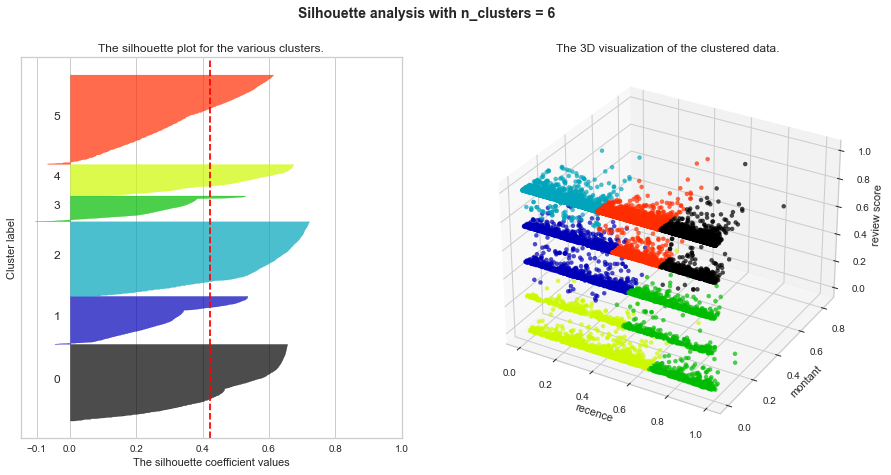

In [81]:
fitted_model = plot_silhouette(KMeans(n_clusters=6, random_state=random_seed), X_sample)

In [82]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample)).sort_values(['recence'])

,recence,montant,review_score,answer_days,mean_items,total_items
2,-288.437657,164.976234,4.992760,2.635495,1.106155,1.220211
1,-265.743540,167.601394,3.622603,2.698208,1.139248,1.247063
4,-233.593413,194.047180,1.171058,2.192914,1.316068,1.389820
5,-157.406872,163.307461,4.785956,2.257019,1.120365,1.191913
3,-84.128373,172.359154,2.103574,2.331875,1.280088,1.323851
0,-51.142683,162.666044,4.773394,2.112285,1.112876,1.151967


>#### On constate que:
> - ça se découpe en trois groupes majeurs (clients actifs / clients peu actifs / clients inactifs)
> - les clients actifs se découpent en 2 sous groupes *(0,3)* : des clients peu satisfaits qui ont dépensé plus que la moyenne et des clients satisfaits qui ont une dépense dans la moyenne.
> - les inactifs se découpent en 3 sous groupes *(1,2,4)*: ceux qui ne sont pas satisfaits *(et ont dépensé plus que la moyenne)*, ceux qui sont modèrement satisfaits et ceux qui sont satisafaits.
> - le groupe des mécontants a changé de temporalité entre le clustering en 5 groupes et celui en 6 groupes.
> - les silhouettes montrent des points mal classés sur les groupes 1, 3 et 5.
> - on a un score qui baisse encore et toujours.

> Ce découpage ne semble pas très naturel.

#### Silhouette avec **7 clusters**

Silhouette score moyen: 0.443


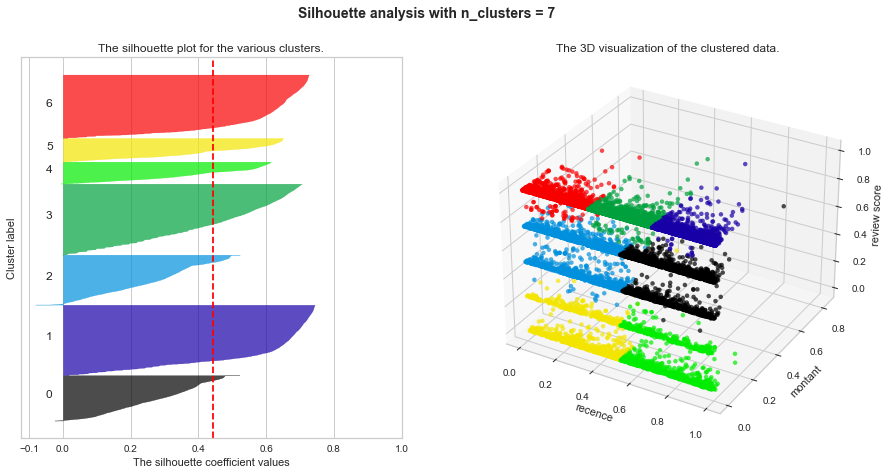

In [83]:
fitted_model = plot_silhouette(KMeans(n_clusters=7, random_state=random_seed), X_sample)

In [84]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample)).sort_values(['recence'])

,recence,montant,review_score,answer_days,mean_items,total_items
6,-298.700177,166.722324,4.992519,2.651833,1.106973,1.229450
2,-262.623313,166.907260,3.659781,2.706886,1.136421,1.243628
5,-258.019124,195.531203,1.219920,2.309695,1.326295,1.419124
3,-178.055981,160.381986,4.994243,2.305167,1.109365,1.186427
4,-107.967466,184.499212,1.246147,2.226455,1.322774,1.351027
0,-94.320132,161.255066,3.720091,2.234839,1.152159,1.202558
1,-60.839414,165.553174,4.998047,2.081536,1.114780,1.154727


>#### On constate que:
> - ça se découpe en trois groupes majeurs (clients actifs / clients peu actifs / clients inactifs)
> - les clients actifs se découpent en 2 sous groupes *(0,1)* : les clients modèrement satisfaits et ceux satisfaits.
> - les clients peu actifs se découpent en 2 sous groupes *(3,4)* : ceux qui ne sont pas satisfaits *(et ont dépensé plus que la moyenne)* et ceux qui sont satisafaits.
> - les clients inactifs se découpent en 3 sous groupes *(2,5,6)* : ceux qui ne sont pas satisfaits *(et ont dépensé plus que la moyenne)*, ceux qui sont modèrement satisfaits et ceux qui sont satisafaits.
> - les silhouettes montrent quelques points mal classés sur les groupes 0 et 2.
> - on a un score qui remonte nettement.

> Ce découpage est plutôt intéressant.

#### Silhouette avec **8 clusters**

Silhouette score moyen: 0.454


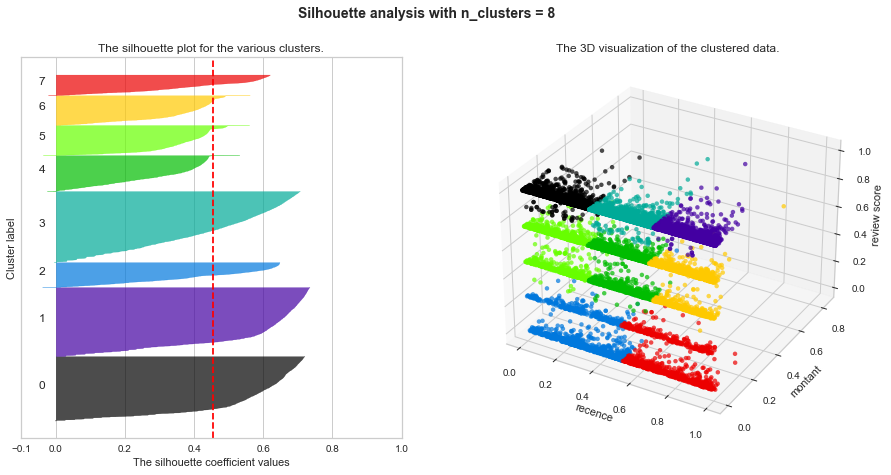

In [85]:
fitted_model = plot_silhouette(KMeans(n_clusters=8, random_state=random_seed), X_sample)

In [86]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample)).sort_values(['recence'])

,recence,montant,review_score,answer_days,mean_items,total_items
5,-298.446317,170.777909,3.671428,2.463674,1.135490,1.235955
0,-297.591688,167.414002,4.993059,2.651216,1.109789,1.229003
2,-253.852830,195.095042,1.213333,2.251824,1.311195,1.400000
4,-183.344322,162.835866,3.668559,2.656986,1.150401,1.246991
3,-175.994729,159.140327,4.994641,2.291645,1.106528,1.181603
7,-103.269827,184.488241,1.254786,2.288514,1.340018,1.365542
6,-64.500631,159.732803,3.730429,2.288352,1.144886,1.193813
1,-59.743555,165.925216,4.998010,2.087427,1.115332,1.156038


>#### On constate que:
> - ça se découpe en trois groupes majeurs (clients actifs / clients peu actifs / clients inactifs)
> - les clients actifs se découpent en 2 sous groupes *(1,6)* : les clients modèrement satisfaits *(et ont dépensé moins que la moyenne)* et ceux satisfaits.
> - les clients peu actifs se découpent en 3 sous groupes *(3,4,7)* : ceux qui ne sont pas satisfaits *(et ont dépensé plus que la moyenne)*, ceux qui sont modèrement satisfaits *(et ont dépensé moins que la moyenne)* et ceux qui sont satisafaits.
> - les clients inactifs se découpent en 3 sous groupes *(0,2,5)* : ceux qui ne sont pas satisfaits *(et ont dépensé plus que la moyenne)*, ceux qui sont modèrement satisfaits et ceux qui sont satisafaits.
> - les silhouettes montrent quelques points mal classés sur les groupes 0 et 2.
> - le score obtenu est le plus haut en dehors du clustering en 3 groupes (qui ne nous satisfait pas).
> - c'est le découpage recommandé par la méthode du coude avec le Le distorition score. 

> Ce découpage est plutôt intéressant.

#### Silhouette avec **9 clusters**

Silhouette score moyen: 0.453


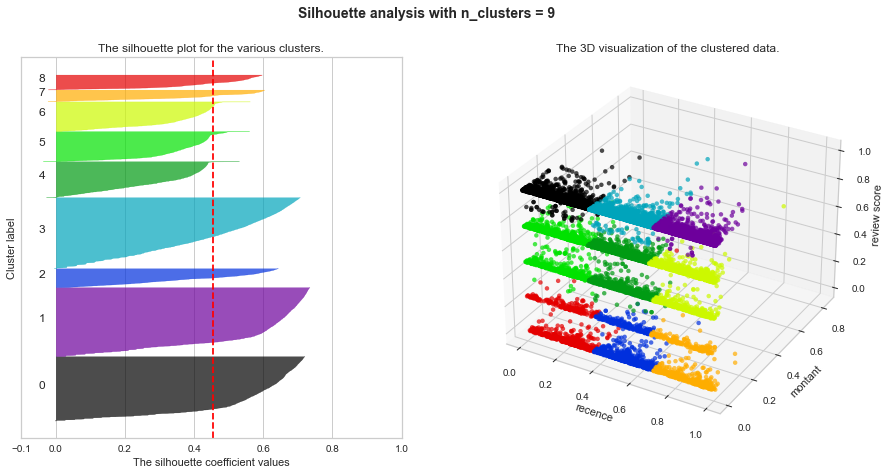

In [87]:
fitted_model = plot_silhouette(KMeans(n_clusters=9, random_state=random_seed), X_sample)

In [88]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample)).sort_values(['recence'])

,recence,montant,review_score,answer_days,mean_items,total_items
5,-298.380774,170.748533,3.671532,2.463986,1.135074,1.234082
0,-297.591688,167.414002,4.993059,2.651216,1.109789,1.229003
8,-288.948428,197.461660,1.242558,2.274214,1.337526,1.426415
4,-183.283029,163.329196,3.666118,2.655352,1.150870,1.250131
2,-178.585244,190.032293,1.196577,2.164673,1.296278,1.356929
3,-175.994729,159.140327,4.994641,2.291645,1.106528,1.181603
7,-64.943639,180.165330,1.269726,2.427536,1.352657,1.371981
6,-64.519899,159.750600,3.731207,2.289482,1.144978,1.193304
1,-59.743555,165.925216,4.998010,2.087427,1.115332,1.156038


>#### On constate que:
> - ça se découpe en trois groupes majeurs (clients actifs / clients peu actifs / clients inactifs)
> - puis chaque groupe est découpé en 3 groupes de satisfactions: ceux qui ne sont pas satisfaits *(et ont dépensé plus que la moyenne)*, ceux qui sont modèrement satisfaits et ceux qui sont satisafaits.
> - les silhouettes montrent quelques points mal classés sur les groupes 0 et 2.
> - on a un score équivalent au découpage en 7 groupes et à peine plus bas que celui en 8 groupes.

> C'est le découpage que je trouve le plus intéressant, mais **aller plus loin dans le découpage n'aurait pas de sens**.

---
---
# 5. Classification Ascendante Hiérarchique *(CAH)* <a class="anchor" id="cah"></a> [⇪](#menu)

La classification ascendante hiérarchique (CAH) est une méthode de classification itérative dont le principe est simple.
1. On calcule la dissimilarité entre les points (ou groupes de points après le premier tour) en utilisant un critère d'agrégation.
2. Puis on regroupe les deux points (ou groupes de points) dont le regroupement minimise le critère choisi.

On continue ainsi jusqu'à ce que tous les objets soient regroupés en un arbre binaire de classification *(dendrogramme)*, dont la racine correspond à la classe regroupant l'ensemble des individus. On peut alors choisir une partition en tronquant l'arbre à un niveau donné, le niveau dépendant soit des contraintes de l'utilisateur *(l'utilisateur sait combien de classes il veut obtenir)*, soit de critères plus objectifs.

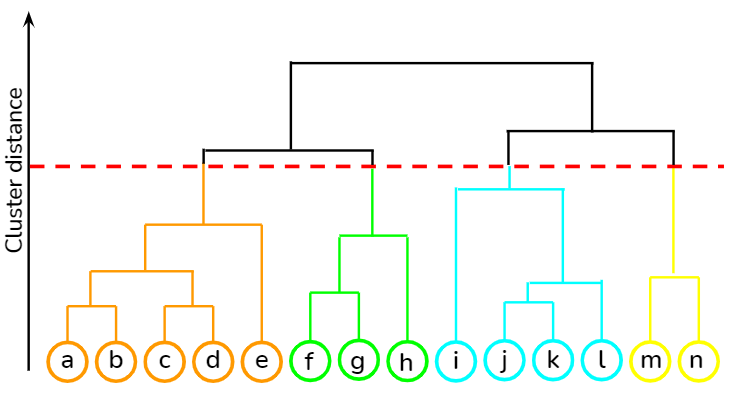

## 5.1 Basic CAH <a class="anchor" id="cah_ref"></a> [⇪](#menu)
#### Commençons par regarder comment se comporte la Classification Ascendante Hiérarchique *(CAH)* avec les données R et M du RFM

In [120]:
from sklearn.cluster import AgglomerativeClustering

In [121]:
X_basic = X_sample[['recence', 'montant']]
cah = AgglomerativeClustering(n_clusters=8).fit(X_basic)

--- CAH [basic] ------------------------------------------------------------------------------------

          SILHOUETTE : 0.4315



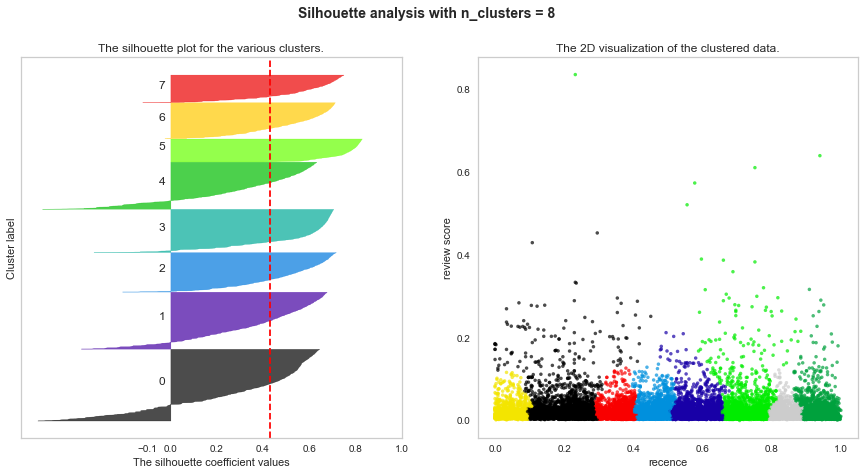

In [122]:
get_clustering_scores("CAH [basic]",  model=cah, X_ref=X_basic, register=True)

> Ce découpage ne présente aucun intérêt pour notre recherche de groupes types de clients.<br>
> Nous allons donc utiliser les variables supplémentaires que nous avons préparé un peu plus tôt.

## 5.2 CAH + Feature Engineering  <a class="anchor" id="cah_fe"></a> [⇪](#menu)
#### Ajoutons les variables que nous avons préparé dans la section Feature Engineering

In [ ]:
X_fe = X_sample
cah = AgglomerativeClustering(n_clusters=8).fit(X_fe)

--- CAH [fe] ---------------------------------------------------------------------------------------

          SILHOUETTE : 0.4210



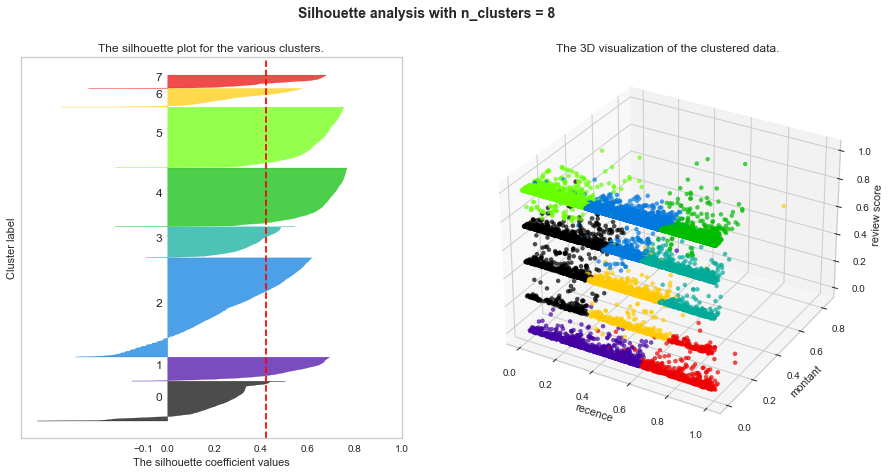

In [ ]:
get_clustering_scores("CAH [fe]",  model=cah, X_ref=X_fe, register=True)

>#### On constate que: **TODO**

## 5.3 CAH + Automatic determination of number of clusters  <a class="anchor" id="cah_auto"></a> [⇪](#menu)

## 5.4 CAH + Silhouettes <a class="anchor" id="cah_silhouette"></a> [⇪](#menu)
Affichons les courbes silhouettes pour diverses valeurs **k** pour mieux visualiser le clustering

#### Silhouette avec **3 clusters**

Silhouette score moyen: 0.408


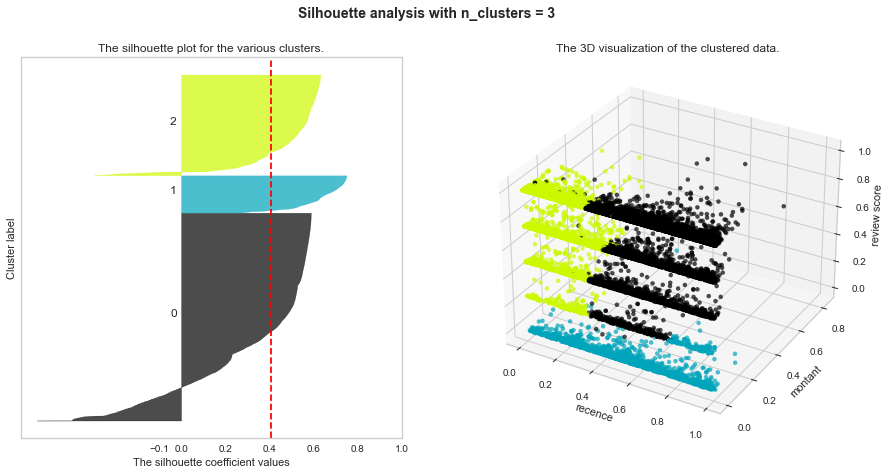

In [105]:
fitted_model = plot_silhouette(AgglomerativeClustering(n_clusters=3), X_sample)

In [106]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample)).sort_values(['recence'])

,recence,montant,review_score,answer_days,mean_items,total_items
2,-294.984913,169.812593,4.436905,2.726840,1.106445,1.218849
1,-178.046899,191.392300,1.061775,2.230459,1.347285,1.392335
0,-122.246234,162.234734,4.546461,2.217851,1.132234,1.197258


>#### On constate que: **TODO**

#### Silhouette avec **4 clusters**

Silhouette score moyen: 0.384


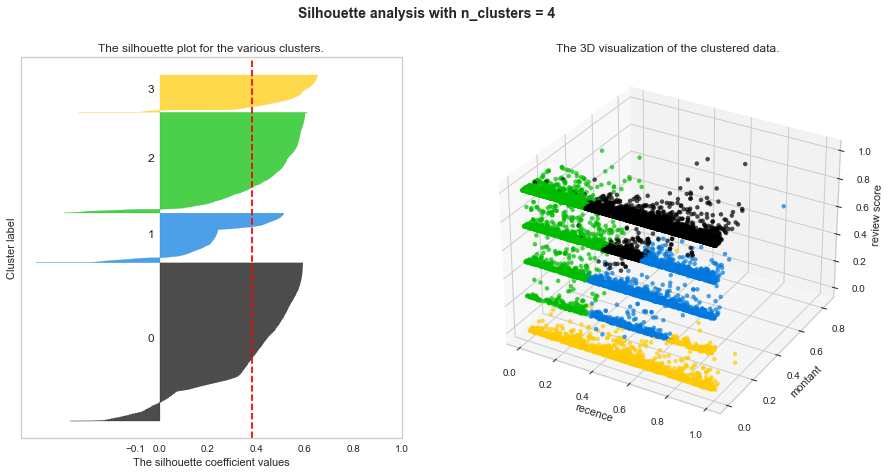

In [107]:
fitted_model = plot_silhouette(AgglomerativeClustering(n_clusters=4), X_sample)

In [108]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample)).sort_values(['recence'])

,recence,montant,review_score,answer_days,mean_items,total_items
2,-294.984913,169.812593,4.436905,2.726840,1.106445,1.218849
3,-178.046899,191.392300,1.061775,2.230459,1.347285,1.392335
0,-126.823620,160.248605,4.904845,2.130141,1.116600,1.179341
1,-107.636673,168.573830,3.402615,2.497795,1.182136,1.254442


>#### On constate que: **TODO**

#### Silhouette avec **5 clusters**

Silhouette score moyen: 0.374


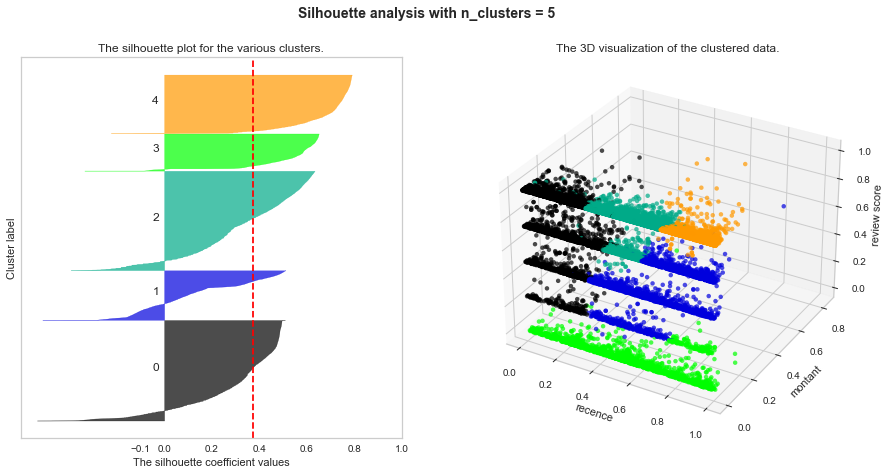

In [109]:
fitted_model = plot_silhouette(AgglomerativeClustering(n_clusters=5), X_sample)

In [110]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample)).sort_values(['recence'])

,recence,montant,review_score,answer_days,mean_items,total_items
0,-294.984913,169.812593,4.436905,2.726840,1.106445,1.218849
3,-178.046899,191.392300,1.061775,2.230459,1.347285,1.392335
2,-171.631857,152.449161,4.850053,2.155950,1.125699,1.204901
1,-107.636673,168.573830,3.402615,2.497795,1.182136,1.254442
4,-51.048135,173.438291,4.997503,2.086495,1.101211,1.136117


>#### On constate que: **TODO**

#### Silhouette avec **6 clusters**

Silhouette score moyen: 0.397


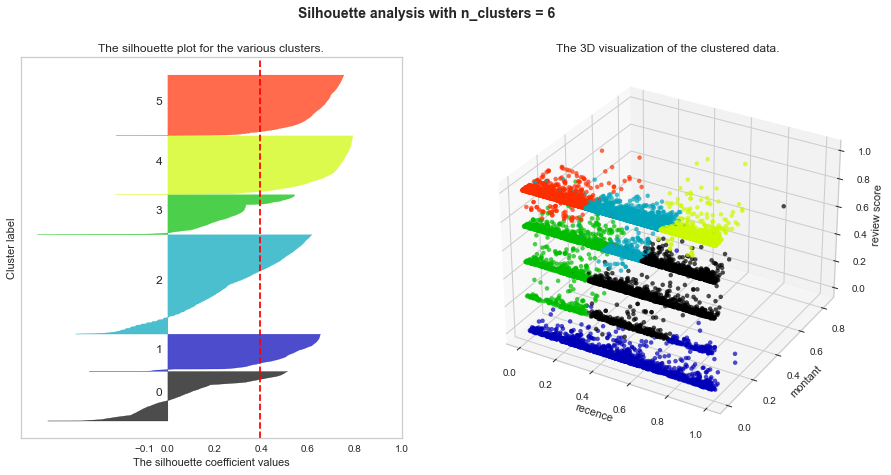

In [111]:
fitted_model = plot_silhouette(AgglomerativeClustering(n_clusters=6), X_sample)

In [112]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample)).sort_values(['recence'])

,recence,montant,review_score,answer_days,mean_items,total_items
5,-300.891667,169.210735,4.991481,3.014866,1.092989,1.203704
3,-285.995773,170.728525,3.592928,2.288511,1.126924,1.241898
1,-178.046899,191.392300,1.061775,2.230459,1.347285,1.392335
2,-171.631857,152.449161,4.850053,2.155950,1.125699,1.204901
0,-107.636673,168.573830,3.402615,2.497795,1.182136,1.254442
4,-51.048135,173.438291,4.997503,2.086495,1.101211,1.136117


>#### On constate que: **TODO**

#### Silhouette avec **7 clusters**

Silhouette score moyen: 0.410


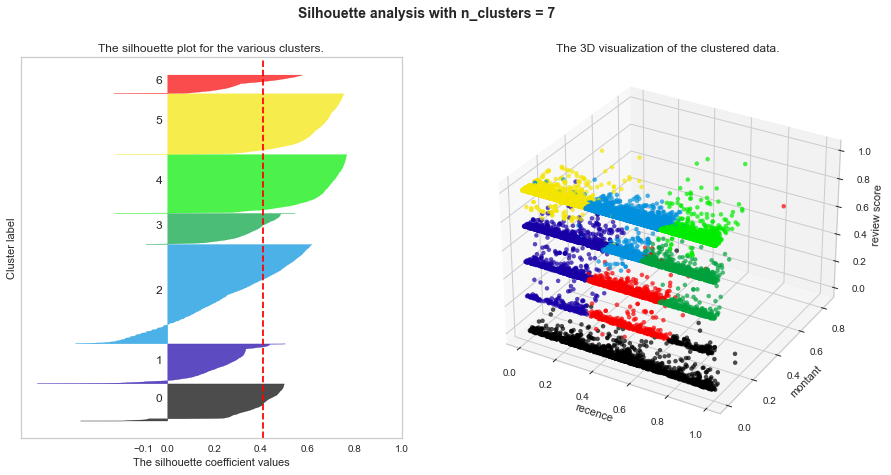

In [113]:
fitted_model = plot_silhouette(AgglomerativeClustering(n_clusters=7), X_sample)

In [114]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample)).sort_values(['recence'])

,recence,montant,review_score,answer_days,mean_items,total_items
5,-300.891667,169.210735,4.991481,3.014866,1.092989,1.203704
1,-285.995773,170.728525,3.592928,2.288511,1.126924,1.241898
0,-178.046899,191.392300,1.061775,2.230459,1.347285,1.392335
6,-172.239437,180.027887,2.742874,2.804494,1.285630,1.419517
2,-171.631857,152.449161,4.850053,2.155950,1.125699,1.204901
3,-68.741975,161.677807,3.799818,2.313144,1.119826,1.155058
4,-51.048135,173.438291,4.997503,2.086495,1.101211,1.136117


>#### On constate que: **TODO**

#### Silhouette avec **8 clusters**

Silhouette score moyen: 0.421


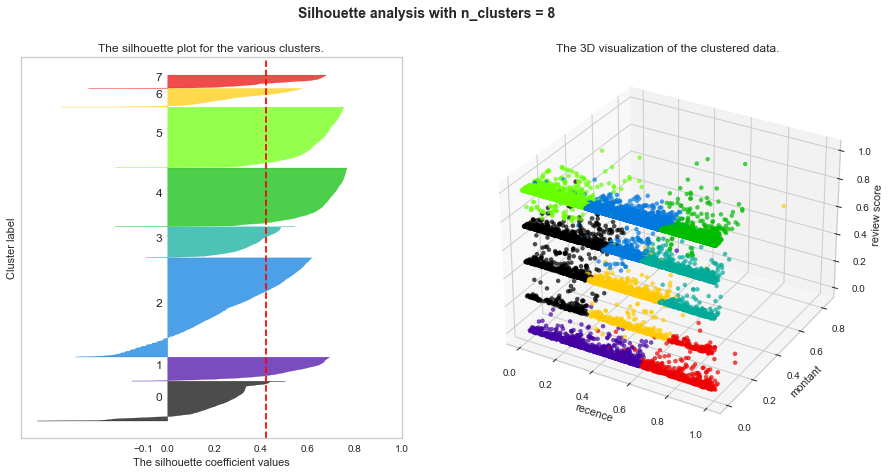

In [115]:
fitted_model = plot_silhouette(AgglomerativeClustering(n_clusters=8), X_sample)

In [116]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample)).sort_values(['recence'])

,recence,montant,review_score,answer_days,mean_items,total_items
5,-300.891667,169.210735,4.991481,3.014866,1.092989,1.203704
0,-285.995773,170.728525,3.592928,2.288511,1.126924,1.241898
1,-234.777255,189.692604,1.000392,2.166275,1.277386,1.338824
6,-172.239437,180.027887,2.742874,2.804494,1.285630,1.419517
2,-171.631857,152.449161,4.850053,2.155950,1.125699,1.204901
7,-75.884181,194.453192,1.172316,2.346045,1.473164,1.488701
3,-68.741975,161.677807,3.799818,2.313144,1.119826,1.155058
4,-51.048135,173.438291,4.997503,2.086495,1.101211,1.136117


>#### On constate que: **TODO**

#### Silhouette avec **9 clusters**

Silhouette score moyen: 0.427


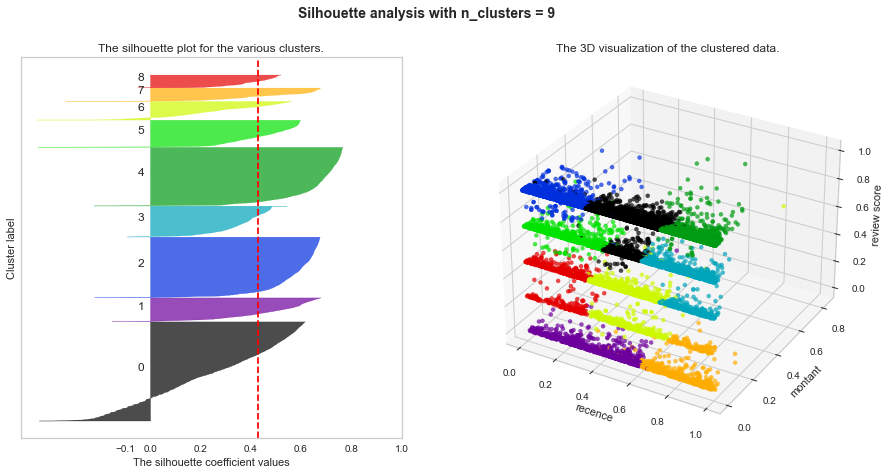

In [117]:
fitted_model = plot_silhouette(AgglomerativeClustering(n_clusters=9), X_sample)

In [118]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_sample)).sort_values(['recence'])

,recence,montant,review_score,answer_days,mean_items,total_items
2,-300.891667,169.210735,4.991481,3.014866,1.092989,1.203704
8,-297.425656,173.875962,2.736557,2.087302,1.146825,1.290087
5,-280.562024,169.232238,4.000046,2.384165,1.117464,1.218988
1,-234.777255,189.692604,1.000392,2.166275,1.277386,1.338824
6,-172.239437,180.027887,2.742874,2.804494,1.285630,1.419517
0,-171.631857,152.449161,4.850053,2.155950,1.125699,1.204901
7,-75.884181,194.453192,1.172316,2.346045,1.473164,1.488701
3,-68.741975,161.677807,3.799818,2.313144,1.119826,1.155058
4,-51.048135,173.438291,4.997503,2.086495,1.101211,1.136117


>#### On constate que: **TODO**

In [119]:
import FreeMobileSMS as sms
sms.send()

JupyterScriptCompleted: Jupyter is waiting

---
---

In [ ]:
import math

In [ ]:
for j in range(3, 8):
    fig = plt.figure(figsize=(15, 7))
    plt.title(f"KMeans with {j} clusters")
    model = KMeans(n_clusters=j, random_state=0)
    visualizer = InterclusterDistance(model, colors='yellowbrick')
    visualizer.fit(X_sample)
    visualizer.show();

In [ ]:
k_range = range(3, 8)
X_xxx = X_sample[['recence', 'montant']]
k_size = len(k_range)
for i, j in enumerate(k_range):
    model = KMeans(n_clusters=j, random_state=0)
    model.fit(X_xxx)

    fig = plt.figure(figsize=(15, 7))
    plt.title(f"KMeans with {j} clusters")
    sns.scatterplot(x=X_xxx['recence'], y=X_xxx['montant'], hue=model.labels_)
    plt.show()